In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math

def preprocess_data(file_path, coin_name):
    df = pd.read_csv(file_path)

    df_new = df[df["symbol"] == coin_name]
    df_new = df_new.drop(columns=["symbol", "datetime"])
    df_new = df_new.reset_index(drop=True)
    df_new = df_new.rename(columns={'date': 'ds', 'price': 'y'})
    
    # Set constant time '12:00:00' for all dates
    df_new['ds'] = pd.to_datetime(df_new['ds']).dt.date.astype(str) + " 12:00:00"
    df_new['ds'] = pd.to_datetime(df_new['ds'])  # Convert back to datetime
    
    # Sort the data by 'ds'
    df_new = df_new.sort_values(by='ds').reset_index(drop=True)

    # Add percentage change as the target variable
    df_new['y_pct_change'] = df_new['y'].pct_change().fillna(0)

    # Add lagged features
    df_new['lag_1'] = df_new['y'].shift(1).fillna(df_new['y'].iloc[0])
    df_new['rolling_mean_3'] = df_new['y'].rolling(window=3).mean().fillna(df_new['y'].iloc[0])

    return df_new

# LightGBM Model
def LGBM_Model(df, horizon=180):
    # Ensure 'ds' is the index
    df = df.set_index('ds')

    # Use percentage change as the target variable
    X = df.drop(['y', 'y_pct_change'], axis=1)
    y = df['y_pct_change']

    # Train-Test Split
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    # LightGBM Modeling
    lgbm = LGBMRegressor(
        random_state=42,
        n_estimators=1000,  # Increase the number of trees
        learning_rate=0.01,  # Lower learning rate for small changes
        num_leaves=31,  # Adjust tree complexity
        min_child_weight=0.1  # Focus on small changes
    )
    lgbm.fit(X_train, y_train)
    lgbm_predictions = lgbm.predict(X_test)

    # Convert predictions to pandas Series with the same index as y_test
    lgbm_predictions_series = pd.Series(lgbm_predictions, index=y_test.index)

    # Rescale predictions back to original scale
    actual_prices = df['y'].iloc[-horizon:]
    predicted_prices = actual_prices.shift(1) * (1 + lgbm_predictions_series)
    predicted_prices = predicted_prices.fillna(actual_prices.iloc[0])

    # Evaluation Metrics
    lgbm_mae = np.round(mean_absolute_error(actual_prices, predicted_prices), 3)
    lgbm_mape = np.round(mean_absolute_percentage_error(actual_prices, predicted_prices), 3)
    lgbm_mse = np.round(mean_squared_error(actual_prices, predicted_prices), 3)
    lgbm_rmse = np.round(math.sqrt(lgbm_mse), 3)

    print(f"MAE: {lgbm_mae}")
    print(f"MAPE: {lgbm_mape}")
    print(f"MSE: {lgbm_mse}")
    print(f"RMSE: {lgbm_rmse}")

    # Plotting Actual vs Predicted
    fig = plt.figure(figsize=(16, 6))
    plt.title('Actual vs LightGBM Predictions', fontsize=20)
    plt.plot(actual_prices, color='red', label='Actual Values')
    plt.plot(predicted_prices, color='green', label='LGBM Predictions')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()

    return lgbm_mae, lgbm_mape, lgbm_mse, lgbm_rmse, fig


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 15
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

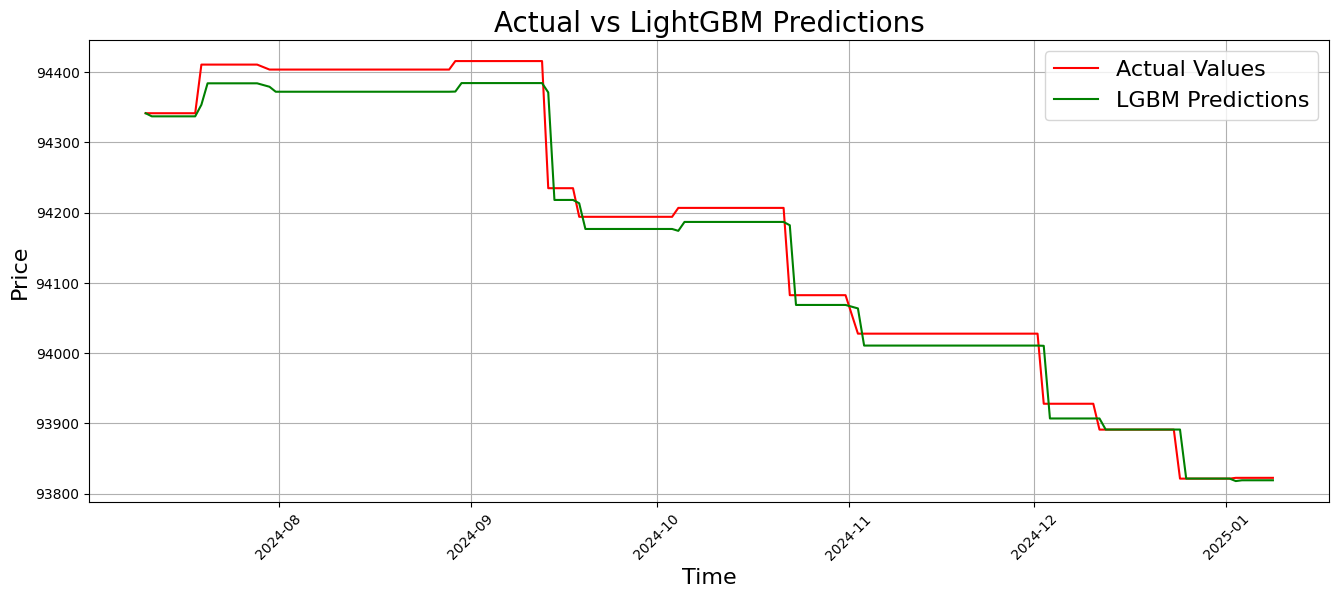

Evaluation Metrics: (20.578, 0.0, 687.489, 26.22, <Figure size 1600x600 with 1 Axes>)


In [2]:
file_path = "/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/artifacts/df_last_year_20250109.csv"
df_btc = preprocess_data(file_path, "BTC")
lgbm_metrics = LGBM_Model(df_btc)

print("Evaluation Metrics:", lgbm_metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 13
[LightGBM] [Info] Start training from score -0.000003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

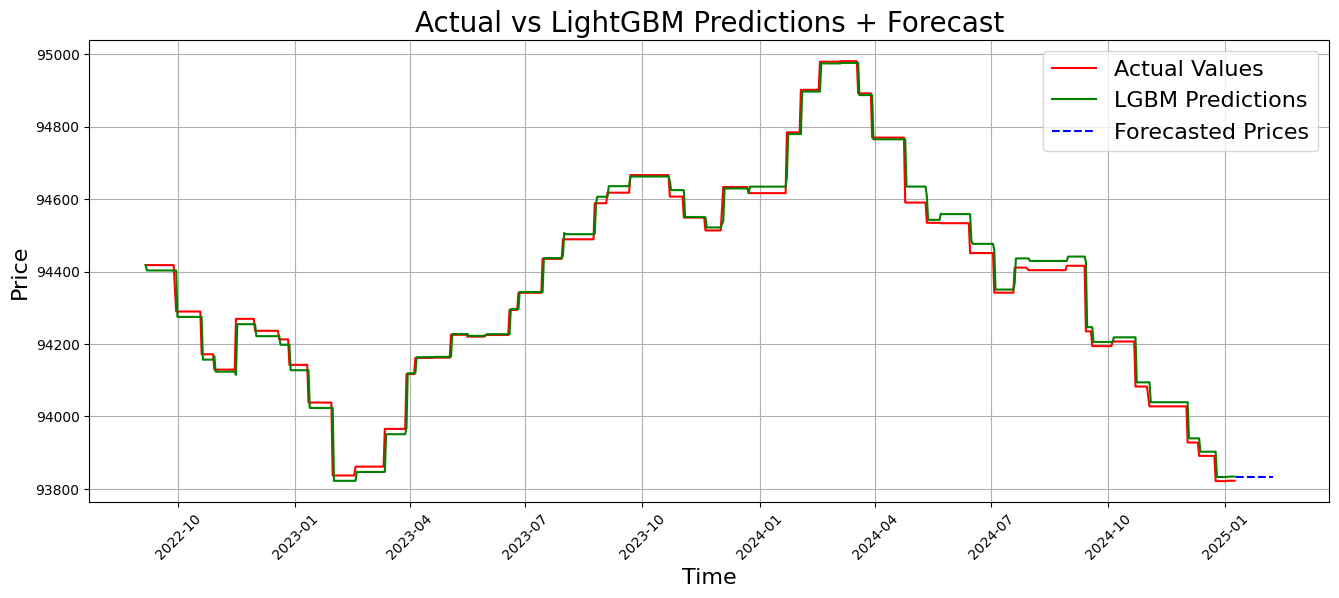

Evaluation Metrics: (15.564, 0.0, 661.759, 25.725, <Figure size 1600x600 with 1 Axes>)


In [11]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")


# Load and Preprocess Data
def preprocess_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Filter for Bitcoin data
    df_btc = df[df["symbol"] == "BTC"]
    df_btc = df_btc.drop(columns=["symbol", "datetime"])
    df_btc = df_btc.reset_index(drop=True)
    df_btc = df_btc.rename(columns={'date': 'ds', 'price': 'y'})
    
    # Set constant time '12:00:00' for all dates
    df_btc['ds'] = pd.to_datetime(df_btc['ds']).dt.date.astype(str) + " 12:00:00"
    df_btc['ds'] = pd.to_datetime(df_btc['ds'])  # Convert back to datetime
    
    # Sort the data by 'ds'
    df_btc = df_btc.sort_values(by='ds').reset_index(drop=True)

    # Add percentage change as the target variable
    df_btc['y_pct_change'] = df_btc['y'].pct_change().fillna(0)

    # Add lagged features
    df_btc['lag_1'] = df_btc['y'].shift(1).fillna(df_btc['y'].iloc[0])
    df_btc['rolling_mean_3'] = df_btc['y'].rolling(window=3).mean().fillna(df_btc['y'].iloc[0])

    return df_btc


def LGBM_Model(df, horizon=850, forecast_horizon=30):
    # Ensure 'ds' is the index
    df = df.set_index('ds')

    # Use percentage change as the target variable
    X = df.drop(['y', 'y_pct_change'], axis=1)
    y = df['y_pct_change']

    # Train-Test Split
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    # LightGBM Modeling
    lgbm = LGBMRegressor(
        random_state=42,
        n_estimators=1000,  # Increase the number of trees
        learning_rate=0.01,  # Lower learning rate for small changes
        num_leaves=31,  # Adjust tree complexity
        min_child_weight=0.1  # Focus on small changes
    )
    lgbm.fit(X_train, y_train)
    lgbm_predictions = lgbm.predict(X_test)

    # Convert predictions to pandas Series with the same index as y_test
    lgbm_predictions_series = pd.Series(lgbm_predictions, index=y_test.index)

    # Rescale predictions back to original scale
    actual_prices = df['y'].iloc[-horizon:]
    predicted_prices = actual_prices.shift(1) * (1 + lgbm_predictions_series)
    predicted_prices = predicted_prices.fillna(actual_prices.iloc[0])

    # Evaluation Metrics
    lgbm_mae = np.round(mean_absolute_error(actual_prices, predicted_prices), 3)
    lgbm_mape = np.round(mean_absolute_percentage_error(actual_prices, predicted_prices), 3)
    lgbm_mse = np.round(mean_squared_error(actual_prices, predicted_prices), 3)
    lgbm_rmse = np.round(math.sqrt(lgbm_mse), 3)

    print(f"MAE: {lgbm_mae}")
    print(f"MAPE: {lgbm_mape}")
    print(f"MSE: {lgbm_mse}")
    print(f"RMSE: {lgbm_rmse}")

    # Forecasting the next `forecast_horizon` days (30 days)
    last_known_data = df.iloc[-1].copy()
    forecast_dates = pd.date_range(df.index[-1], periods=forecast_horizon + 1, freq='D')[1:]

    forecasted_prices = []
    last_features = X.iloc[-1, :].values.reshape(1, -1)

    for i in range(forecast_horizon):
        forecast_pct_change = lgbm.predict(last_features)[0]
        forecasted_prices.append(actual_prices.iloc[-1] * (1 + forecast_pct_change))
        last_known_data['y'] = forecasted_prices[-1]  # Update the last known data
        last_known_data['y_pct_change'] = forecast_pct_change  # Update the pct_change
        last_known_data['lag_1'] = forecasted_prices[-1]  # Update lag_1 feature
        last_known_data['rolling_mean_3'] = np.mean([forecasted_prices[-1], actual_prices.iloc[-1], actual_prices.iloc[-2]])  # Update rolling mean

        # Update the features for the next prediction (Use all features, not just 'lag_1' and 'rolling_mean_3')
        last_features = last_known_data[X.columns].values.reshape(1, -1)

    forecasted_dates = pd.Series(forecast_dates, name='ds')
    forecasted_prices_series = pd.Series(forecasted_prices, name='y')

    # Plotting Actual vs Predicted + Forecast
    fig = plt.figure(figsize=(16, 6))
    plt.title('Actual vs LightGBM Predictions + Forecast', fontsize=20)
    plt.plot(actual_prices, color='red', label='Actual Values')
    plt.plot(predicted_prices, color='green', label='LGBM Predictions')
    plt.plot(forecasted_dates, forecasted_prices_series, color='blue', label='Forecasted Prices', linestyle='--')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()

    return lgbm_mae, lgbm_mape, lgbm_mse, lgbm_rmse, fig



file_path = "/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/artifacts/df_last_year_20250109.csv"
df_btc = preprocess_data(file_path)
lgbm_metrics = LGBM_Model(df_btc)

print("Evaluation Metrics:", lgbm_metrics)


In [5]:
df1 = pd.read_csv("/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/artifacts/df_last_year_20250109.csv")
df1 = df1[df1["symbol"] == "BTC"]
df1.head()

,datetime,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply,date
4,2025-01-09 00:38:38,BTC,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,2022-02-24
18,2025-01-09 00:38:34,BTC,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,2022-02-25
30,2025-01-09 00:38:33,BTC,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,2022-02-26
43,2025-01-09 00:38:30,BTC,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,2022-02-27
55,2025-01-09 00:38:28,BTC,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,2022-02-28


In [7]:
dfold = pd.read_csv("/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/coindata.csv")
dfold = dfold[dfold["symbol"] == "BTC"]
dfold.head()

,Unnamed: 0,date,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply
4745,5099,2024-01-04,BTC,96346.469194,4.292041e+10,59.6342,-1.132631,2.666368,0.390144,0.874424,40.825541,55.461078,1.908116e+12,55.997,2.023276e+12,19804734.0,19804734.0
4746,5085,2024-01-05,BTC,96346.469194,4.292041e+10,59.6342,-1.132631,2.666368,0.390144,0.874424,40.825541,55.461078,1.908116e+12,55.997,2.023276e+12,19804734.0,19804734.0
4747,5071,2024-01-06,BTC,96346.469194,4.292041e+10,59.6342,-1.132631,2.666368,0.390144,0.874424,40.825541,55.461078,1.908116e+12,55.997,2.023276e+12,19804734.0,19804734.0
4748,5057,2024-01-07,BTC,96346.469194,4.292041e+10,59.6342,-1.132631,2.666368,0.390144,0.874424,40.825541,55.461078,1.908116e+12,55.997,2.023276e+12,19804734.0,19804734.0
4749,5043,2024-01-08,BTC,96346.469194,4.292041e+10,59.6342,-1.132631,2.666368,0.390144,0.874424,40.825541,55.461078,1.908116e+12,55.997,2.023276e+12,19804734.0,19804734.0


In [8]:
dfold.tail(10)

,Unnamed: 0,date,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply
5100,129,2024-12-24,BTC,97449.716651,4.225071e+10,54.4383,0.934672,4.055179,1.179343,2.278695,42.478912,56.649079,1.929966e+12,56.5017,2.046444e+12,19804734.0,19804734.0
5101,115,2024-12-25,BTC,97449.716651,4.225071e+10,54.4383,0.934672,4.055179,1.179343,2.278695,42.478912,56.649079,1.929966e+12,56.5017,2.046444e+12,19804734.0,19804734.0
5102,101,2024-12-26,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5103,87,2024-12-27,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5104,73,2024-12-28,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5105,59,2024-12-29,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5106,45,2024-12-30,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5107,31,2024-12-31,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5108,17,2025-01-01,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
5109,3,2025-01-02,BTC,97454.535636,4.224207e+10,54.4009,1.027793,4.016997,1.101377,2.301396,42.461561,56.693444,1.930061e+12,56.5045,2.046545e+12,19804734.0,19804734.0
